# Define the Problem

This script models g(**x**) (called eqn), then finds P(g) > 155900  with a Monte Carlo on an ANN model of g (called model)

In [1]:
# Define g(x)
def eqn(a,b,c,d,e,f,g):
     f = ( ( a*(b**2) )/( 2*(b**3) ) )*( ( d**2 - 4*e*f*(g**2) + d*(f + 4*e + 2*f*g) )/( d*e*(d+f+2*f*g) ))
     return f

In [2]:
# Define means and std of all 7 Normal RVs
m1, s1 = 350, 35
m2, s2 = 50.8, 5.08
m3, s3 = 3.81, 0.381
m4, s4 = 173, 17.3
m5, s5 = 9.38, 0.938
m6, s6 = 33.1, 3.31
m7, s7 = 0.036, 0.0036

# Generate data

Create a sample from the distros, find thier outputs, create a dataframe with all the data, split in to train and test dataframes

In [3]:
# Imports
import numpy as np     
import pandas as pd       # For the dataframe class
import seaborn as sns     # For plotting
sns.set(color_codes=True) # Config sns 
from pyDOE import lhs     # For latin hypercube
import scipy.stats as st  # For stats

In [4]:
# Generate sample
ss = 10000     # Sample size
means = [m1,m2,m3,m4,m5,m6,m7]
cov = np.diag([s1,s2,s3,s4,s5,s6,s7])

# Latin hypercube sampling
latin = lhs(7, samples=ss) # 7D lhc between 0 and 1
for i in range(7):
    latin[:,i] = st.norm(loc=means[i], scale=cov[i,i]).ppf(latin[:,i]) # reverse cdf: [0,1] -> Normals
X = latin

# Convert to pandas datafame
ds = pd.DataFrame(X)

In [5]:
# Generate outputs, g(each sampling)
out = []
for i in range(0, ss):
    y = eqn(*X[i])
    out.append(y)
#out

In [6]:
# Add oututs to dataframe
ds['output'] = out
ds.head() 

,0,1,2,3,4,5,6,output
0,441.856719,44.480787,3.851793,125.288519,10.438003,35.362147,0.033131,0.597693
1,392.629839,51.990036,3.210053,172.065242,9.555935,41.333757,0.037224,0.464897
2,316.383241,49.384586,3.866173,130.523594,11.855513,36.267775,0.027992,0.346072
3,328.656836,55.902564,4.160630,186.714050,8.231951,33.647302,0.036137,0.409854
4,350.068893,45.411579,3.314541,180.687689,8.315000,36.384515,0.031432,0.533819


In [7]:
# create training and testing ds, 80:20 split
d_train = ds.sample(frac=0.8,random_state=0) # 80% sample of ds
d_test = ds.drop(d_train.index)              # ds - d_train

Wall time: 5.41 s


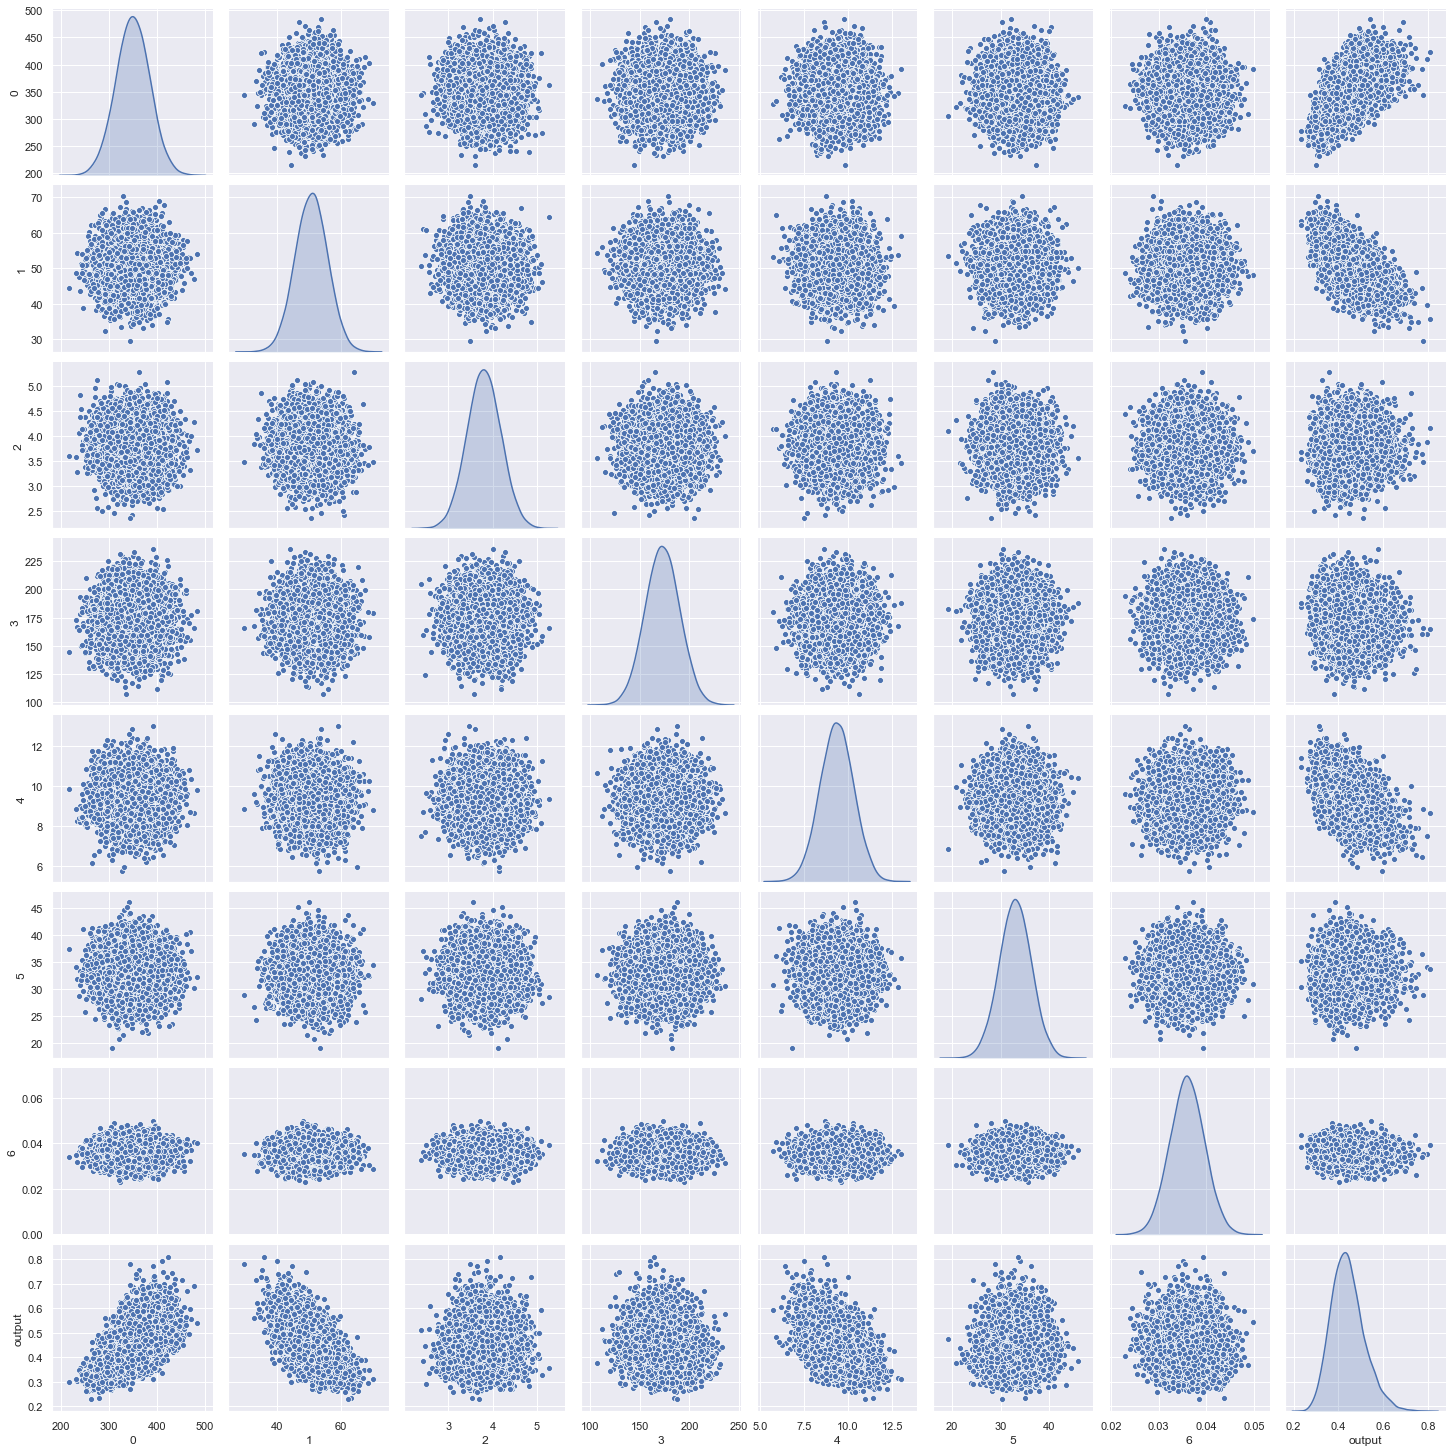

In [8]:
%%time
# Visualise all distros
sns.pairplot(d_train, diag_kind="kde")

# Modelling

Use TensorFlow to train an ANN to model g

In [9]:
# Imports
import tensorflow as tf       # Package for machine learning
from tensorflow import keras
from tensorflow.keras import layers

# Check GPU found for GPU acceleration. Requries nvidia GPU with CUDA ANN drivers
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
# Seperate input and output
l_train = d_train.pop('output')
l_test  = d_test.pop('output')
print(d_train.head())
print(l_train.head())

               0          1         2           3          4          5  \
9394  368.970143  54.323213  3.937232  151.110818  10.224075  33.841005   
898   299.091236  54.105928  4.325425  154.491801   8.514531  35.451731   
2398  325.023282  59.142122  3.181588  177.365772   8.212497  32.466729   
5906  355.982110  52.149790  3.751996  176.339548  11.042102  35.034075   
2343  324.304372  52.053070  4.132022  175.187680   9.104645  31.616584   

             6  
9394  0.039583  
898   0.035854  
2398  0.037403  
5906  0.034396  
2343  0.032921  
9394    0.404537
898     0.382035
2398    0.386358
5906    0.372942
2343    0.401788
Name: output, dtype: float64


In [11]:
# Nomalise the data for faster training
train_stats = d_train.describe().transpose()
test_stats = d_test.describe().transpose()

def norm_train(x):
    return (x - train_stats['mean']) / train_stats['std']
def norm_test(x):
    return (x - test_stats['mean']) / test_stats['std']


d_train = norm_train(d_train)
d_test = norm_test(d_test)
d_test.head()

,0,1,2,3,4,5,6
0,2.669793,-1.274909,0.078793,-2.779226,1.108895,0.655737,-0.754794
13,1.012384,0.424864,0.886492,-0.420503,-0.022625,-1.449839,0.485919
21,0.367068,-0.779765,0.497314,0.490777,-1.800827,0.157551,0.363666
25,0.748629,-1.660184,-2.068697,0.350184,0.088575,1.342403,1.871890
26,1.696819,-1.085783,1.282877,-1.322365,-0.015518,-0.326365,-0.319232


**Note** Model requires normalised data input !

In [12]:
# Set up model architecture
EPOCHS = 1000 # Early stopping will be used

model = keras.Sequential([
            layers.Dense(25, activation='relu', input_shape=[7], use_bias=True),
            layers.Dense(25, activation='relu',use_bias=True),
            #layers.Dense(10, activation='relu',use_bias=True),
            #layers.Dense(10, activation='relu',use_bias=True),
            layers.Dense(1)
            ])
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)  
#This line will stop the model early if it doesnt improve much in the last 10 epochs in the validation data, prevents overfitting

In [13]:
# Check Model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 876
Trainable params: 876
Non-trainable params: 0
_________________________________________________________________


In [14]:
%%time 
# Fit the model and save its history for analysis
history = model.fit(d_train, l_train, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop])

Wall time: 42.6 s


# Analysis

Final MAE, MAE over epochs graph, predictions, predictions vs actual graph and R^2. P(fail) from test data

In [15]:
# Evaluate performance on test data
loss, mae, mse = model.evaluate(d_test, l_test, verbose=0)
print("Testing set Mean Abs Error:", mae)

Testing set Mean Abs Error: 0.0022986212


In [16]:
# Imports
#!pip install -q git+https://github.com/tensorflow/docs # run on google colab
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs   # For pltting mae
import tensorflow_docs.plots
from sklearn.metrics import r2_score # For R^2

Text(0.5, 1.0, 'MAE as training progresses')

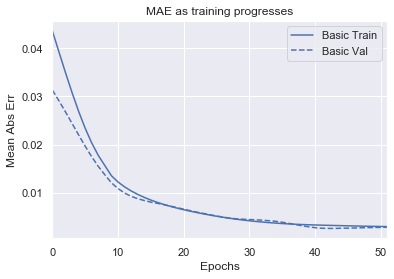

In [17]:
# Visualise accuracy of time
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
#plt.ylim([0, .08])
plt.ylabel('Mean Abs Err')
plt.title('MAE as training progresses')

In [18]:
# Generate predicted labels for test data
pred_test = model.predict(d_test).flatten()
print(pred_test)

[0.59755975 0.46091145 0.5667746  ... 0.30145544 0.4100598  0.44722742]


Text(0.5, 1.0, 'Actual v Predicted Values')

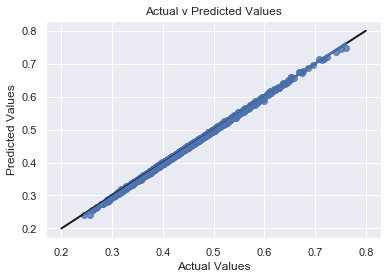

In [19]:
# Plot predicted vs actual labels
x = np.linspace(0.2,0.8,100) # Adjust for graph

# Set up fingure
fig, ax = plt.subplots()
ax.plot(x,x,'k-',lw=2)
sns.regplot(x=l_test, y=pred_test, ax=ax)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Actual v Predicted Values')

In [20]:
# R Squared score
r2 = r2_score(l_test,pred_test)
print("R^2 score =",r2)

R^2 score = 0.9986677075861825


In [21]:
# P fail from test data
fail = [x for x in pred_test if x<0]   #>= 15.59*(10**4)] # Gather failures
pFail = len(fail)/len(d_test)                      # Count and ratio

print("From the test data, P(fail) =", pFail)

From the test data, P(fail) = 0.0


# Monte Carlo to find P(fail)

ie p(g)>155900

Use a large sample for a crude MC method analysis to find pFail

In [27]:
%%time
# Generate new larger sample
ssNew = 1000000 # Sample size

Xn = lhs(7, samples=ssNew) # 7D lhc between 0 and 1
for i in range(7):
    Xn[:,i] = st.norm(loc=means[i], scale=cov[i,i]).ppf(Xn[:,i]) # reverse cdf: [0,1] -> Normals

# Nomalise the data for model input
dsn = pd.DataFrame(Xn) 
dsn_stats = dsn.describe().transpose()
def norm_new(x):
    return (x - dsn_stats['mean']) / dsn_stats['std']
dsn = norm_new(dsn)

dsn.head()

Wall time: 4.02 s


,0,1,2,3,4,5,6
0,0.430290,1.044612,0.232759,-0.905254,-0.551515,0.534109,0.586535
1,0.466296,-0.576654,-1.070519,0.446494,-1.178091,0.226789,-0.286470
2,-0.583756,0.978047,0.527626,-1.926760,1.164853,-1.765535,-0.073548
3,0.616638,-0.070973,-0.635143,-0.297552,0.926398,-0.945953,-1.092046
4,2.212491,1.211859,0.756457,0.754535,-0.130916,0.471003,-1.235669


In [28]:
%%time
# New sample predictions
pred_new = model.predict(dsn).flatten()
#pred_new

Wall time: 45.4 s


In [32]:
# P(fail) from new predictions
failn = [x for x in pred_new if x > 155900]
pFailn = len(failn)/len(dsn)

print("Given this sample (size =",ssNew,"), P(fail) =", pFailn)

Given this sample (size = 1000000 ), P(fail) = 0.0


In [51]:
# Checking with normal approximation

# Normal distro parameters from pred_new
sigm = np.std(pred_new)     
mu = np.mean(pred_new) 

# Display parameters
truemean = eqn(m1,m2,m3,m4,m5,m6,m7)
print("f(X) true mean =",truemean)
print("f(X) sample mean =", mu)
print("f(X) sample std =", sigm)

# Normalise
t = (155900-mu)/sigm

# p(z>t) from normal CDF
prob = 1 - st.norm.cdf(8)
print("Using normal approximation, P(f<0) =", prob)
t

f(X) true mean = 0.4333359950590159
f(X) sample mean = 0.4381743
f(X) sample std = 0.074424304
Using normal approximation, P(f<0) = 6.661338147750939e-16


2094739.934458304

In [36]:
%%time
# Direct MC on eqn outputs

# Generate Outputs
outn = []
for i in range(ssNew):
        y = eqn(*Xn[i])
outn.append(y)

# P fail
fail_outn = [x for x in outn if x > 155900]
pFail_outn = len(fail_outn)/len(outn)

print("Given this crude MC (size =",ssNew,"), P(fail) =", pFail_outn)

Given this crude MC (size = 1000000 ), P(fail) = 0.0
Wall time: 5.91 s
